<a href="https://colab.research.google.com/github/ActionPace/DeepLearningTests/blob/master/Aliens_Keras_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Import dependencies

In [0]:
!wget https://s3.amazonaws.com/machinelearningfiles/alien_vs_predator_thumbnails.zip

--2019-05-08 13:49:59--  https://s3.amazonaws.com/machinelearningfiles/alien_vs_predator_thumbnails.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.0.227
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.0.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7397594 (7.1M) [application/zip]
Saving to: ‘alien_vs_predator_thumbnails.zip’

alien_vs_predator_t 100%[===================>]   7.05M  2.46MB/s    in 2.9s    

2019-05-08 13:50:02 (2.46 MB/s) - ‘alien_vs_predator_thumbnails.zip’ saved [7397594/7397594]



In [0]:
!unzip alien_vs_predator_thumbnails.zip

Archive:  alien_vs_predator_thumbnails.zip
   creating: data/
   creating: data/validation/
   creating: data/train/
   creating: data/validation/predator/
  inflating: data/validation/predator/99.jpg  
  inflating: data/validation/predator/98.jpg  
  inflating: data/validation/predator/97.jpg  
  inflating: data/validation/predator/96.jpg  
  inflating: data/validation/predator/95.jpg  
  inflating: data/validation/predator/94.jpg  
  inflating: data/validation/predator/93.jpg  
  inflating: data/validation/predator/92.jpg  
  inflating: data/validation/predator/91.jpg  
  inflating: data/validation/predator/90.jpg  
  inflating: data/validation/predator/89.jpg  
  inflating: data/validation/predator/88.jpg  
  inflating: data/validation/predator/87.jpg  
  inflating: data/validation/predator/86.jpg  
  inflating: data/validation/predator/85.jpg  
  inflating: data/validation/predator/84.jpg  
  inflating: data/validation/predator/83.jpg  
  inflating: data/validation/predator/82.jpg 

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model, model_from_json

In [0]:
tensorflow.keras.__version__

'2.2.4-tf'

### 2. Create Keras data generators 

In [0]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    'data/validation',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 3. Create the network

In [0]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


In [0]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [0]:
optimizer = tensorflow.keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### 4. Train the model

In [0]:
history = model.fit_generator(generator=train_generator,
                              epochs=3,
                              validation_data=validation_generator)

Epoch 1/3
22/22 [==============================] - 13s 588ms/step - loss: 0.4287 - acc: 0.8055 - val_loss: 0.1892 - val_acc: 0.9350
Epoch 2/3
22/22 [==============================] - 7s 318ms/step - loss: 0.1454 - acc: 0.9452 - val_loss: 0.2131 - val_acc: 0.9150
Epoch 3/3
22/22 [==============================] - 8s 363ms/step - loss: 0.0897 - acc: 0.9669 - val_loss: 0.1518 - val_acc: 0.9450


### 5. Save and load the model

In [0]:
# architecture and weights to HDF5
model.save('model.h5')

# architecture to JSON, weights to HDF5
model.save_weights('weights.h5')
with open('architecture.json', 'w') as f:
        f.write(model.to_json())

In [0]:
# architecture and weights from HDF5
model = load_model('model.h5')

# architecture from JSON, weights from HDF5
with open('architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('weights.h5')

### 6. Make predictions on sample test images

In [0]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [0]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [0]:
pred_probs = model.predict(validation_batch)

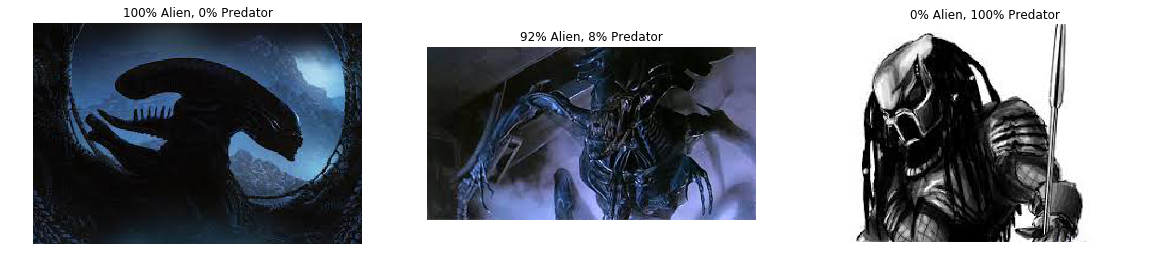

In [0]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)